# Домашнее задание по теме «Многослойная нейронная сеть»

## Задание
Постройте модель на основе полносвязных слоёв для классификации Fashion MNIST из библиотеки torchvision (datasets).
Получите качество на тестовой выборке не ниже 88%

Инструкция по выполнению задания

1. Скачайте тренировочную и тестовою часть датасета Fashion MNIST
2. Постройте модель, выбрав стартовую архитектуру
3. Обучите модель и сверьте качество на тестовой части с заданным порогом
4. Изменяйте архитектуру модели пока качество на тестовой части не будет выше порога. Вариации архитектуры можно реализовать через изменение количества слоёв, количества нейронов в слоях и использование регуляризации. Можно использовать различные оптимизаторы.

# Импорт библиотек

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from numba import cuda

In [6]:
import time

In [7]:
import numpy as np
import pandas as pd

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import torch
import torchvision as tv
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

# Параметры GPU

In [11]:
print(f"CUDA поддерживается системой?")
if torch.cuda.is_available() == True:
    print(f"CUDA-версия: {torch.version.cuda}")
    cuda_id = torch.cuda.current_device()
    print(f"ID текущего CUDA устройства:{torch.cuda.current_device()}")
    print(f"Имя текущего CUDA устройства:{torch.cuda.get_device_name(cuda_id)}")
else:
    print(f"Нет")

CUDA поддерживается системой?
CUDA-версия: 11.8
ID текущего CUDA устройства:0
Имя текущего CUDA устройства:NVIDIA GeForce RTX 2060


# Выбор процессора

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Очистка VRAM GPU

In [15]:
torch.cuda.empty_cache()

# Ввод параметров

In [17]:
THRESHOLD = 0.90
BATCH_SIZE = 32
n_out = 256
learning_rate = 0.001
epochs = 10

# Импорт данных

In [19]:
train_data = tv.datasets.FashionMNIST("./input", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data = tv.datasets.FashionMNIST("./input", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

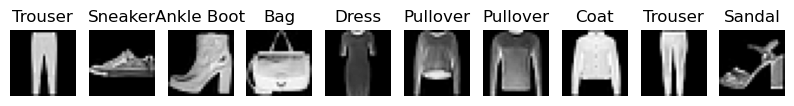

In [20]:
labels_map={
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 10, 1

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()
     

In [21]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=BATCH_SIZE)

Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) <built-in method type of Tensor object at 0x0000024D1D569630>


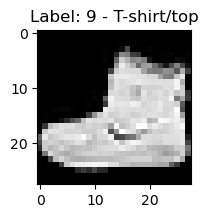

Labels batch shape: torch.Size([32])


In [22]:
for X,y in train_loader:
    figure = plt.figure(figsize = (2,2))
    train_features, train_labels = next(iter(train_loader))
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.type}')
    image = train_features[0].squeeze()
    label = train_labels[0].squeeze()
    sample_idx= torch.randint((label), size = (1,)).item()
    plt.title(f"Label: {label} - {labels_map[sample_idx]}")
    plt.imshow(image, cmap="gray")
    plt.show()
    print(f"Labels batch shape: {train_labels.size()}")
    break

# Стартовая модель

## Функция модели

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, n_out),
            nn.ReLU(),
            nn.Linear(n_out, n_out),
            nn.ReLU(),
            nn.Linear(n_out, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

## Функция обучения

In [27]:
def trainloop (dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device),y.to(device)
        prediction = model(X)
        loss = loss_fn(prediction, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss:{loss:>7f} [{current:>5d}/{size:>5d}]')

## Функция оценки

In [29]:
def evaluate (dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f'Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')
    return 100 * correct, test_loss

## Создание модели

In [31]:
model = NeuralNetwork().to(device)

## Функция потерь

In [33]:
loss_fn = nn.CrossEntropyLoss()

## Оптимизатор

In [35]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Обучение стартовой модели

In [37]:
accuracy_max = 0
test_loss_opt = 0
epoch_opt = 1
for i in range(epochs):
    print(f"Epoch {i+1}")
    trainloop(train_loader, model, loss_fn, optimizer)
    accuracy, test_loss = evaluate(test_loader, model, loss_fn)
    if accuracy > accuracy_max:
      accuracy_max = accuracy
      test_loss_opt = test_loss
      epoch_opt = i

Epoch 1
loss:2.320043 [    0/60000]
loss:2.296652 [ 3200/60000]
loss:2.286530 [ 6400/60000]
loss:2.279234 [ 9600/60000]
loss:2.266034 [12800/60000]
loss:2.246635 [16000/60000]
loss:2.228083 [19200/60000]
loss:2.223799 [22400/60000]
loss:2.228174 [25600/60000]
loss:2.175280 [28800/60000]
loss:2.170657 [32000/60000]
loss:2.136694 [35200/60000]
loss:2.187041 [38400/60000]
loss:2.118038 [41600/60000]
loss:2.101022 [44800/60000]
loss:2.083559 [48000/60000]
loss:2.106301 [51200/60000]
loss:2.037429 [54400/60000]
loss:1.978238 [57600/60000]
Test Error: Accuracy: 47.5%, Avg loss: 1.976148 

Epoch 2
loss:1.967509 [    0/60000]
loss:1.989954 [ 3200/60000]
loss:1.930054 [ 6400/60000]
loss:1.869967 [ 9600/60000]
loss:1.837675 [12800/60000]
loss:1.862322 [16000/60000]
loss:1.705469 [19200/60000]
loss:1.705025 [22400/60000]
loss:1.711194 [25600/60000]
loss:1.629884 [28800/60000]
loss:1.531823 [32000/60000]
loss:1.462425 [35200/60000]
loss:1.645457 [38400/60000]
loss:1.514177 [41600/60000]
loss:1.443

In [38]:
print(f'Точность стартовой модели {accuracy_max}%')

Точность стартовой модели 77.59%


# Изменённая модель

In [40]:
optimizer_new = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [41]:
accuracy_max_new = 0
test_loss_opt_new = 0
epoch_opt_new = 1
for i in range(epochs):
    print(f"Epoch {i+1}")
    trainloop(train_loader, model, loss_fn, optimizer_new)
    accuracy, test_loss = evaluate(test_loader, model, loss_fn)
    if accuracy > accuracy_max_new:
      accuracy_max_new = accuracy
      test_loss_opt_new = test_loss
      epoch_opt_new = i

Epoch 1
loss:0.502108 [    0/60000]
loss:0.779705 [ 3200/60000]
loss:0.439784 [ 6400/60000]
loss:0.717013 [ 9600/60000]
loss:0.472978 [12800/60000]
loss:0.940995 [16000/60000]
loss:0.415278 [19200/60000]
loss:0.364537 [22400/60000]
loss:0.437390 [25600/60000]
loss:0.379312 [28800/60000]
loss:0.533778 [32000/60000]
loss:0.409247 [35200/60000]
loss:0.395898 [38400/60000]
loss:0.519128 [41600/60000]
loss:0.640080 [44800/60000]
loss:0.447658 [48000/60000]
loss:0.450332 [51200/60000]
loss:0.412859 [54400/60000]
loss:0.515130 [57600/60000]
Test Error: Accuracy: 84.3%, Avg loss: 0.431551 

Epoch 2
loss:0.282005 [    0/60000]
loss:0.390502 [ 3200/60000]
loss:0.205107 [ 6400/60000]
loss:0.453878 [ 9600/60000]
loss:0.336202 [12800/60000]
loss:0.828603 [16000/60000]
loss:0.269476 [19200/60000]
loss:0.222850 [22400/60000]
loss:0.358689 [25600/60000]
loss:0.270965 [28800/60000]
loss:0.476250 [32000/60000]
loss:0.381410 [35200/60000]
loss:0.333835 [38400/60000]
loss:0.540657 [41600/60000]
loss:0.687

In [42]:
print(f'Точность стартовой модели {accuracy_max_new}%')

Точность стартовой модели 88.13%


# Итог

In [44]:
print(f'Оптимизатор {optimizer_new.__class__.__name__} улучшил качество модели на {accuracy_max_new - accuracy_max:.1f}%')

Оптимизатор RMSprop улучшил качество модели на 10.5%
